**Importing the necessary libraries**


In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

**Preparing the dataset**

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/fish_health.zip"

Archive:  /content/drive/MyDrive/fish_health.zip
   creating: fish_health/healthy/
  inflating: fish_health/healthy/20180605_145616.jpg  
  inflating: fish_health/healthy/20180605_145627.jpg  
  inflating: fish_health/healthy/20180606_130901.jpg  
  inflating: fish_health/healthy/20180606_131343.jpg  
  inflating: fish_health/healthy/20180606_131350.jpg  
  inflating: fish_health/healthy/2416900.jpg  
  inflating: fish_health/healthy/5bd403bd7db5b70251676b06e42fabce.jfif  
  inflating: fish_health/healthy/a_red_tilapia_stock (10).jpg  
  inflating: fish_health/healthy/a_red_tilapia_stock (11).jpg  
  inflating: fish_health/healthy/a_red_tilapia_stock (12).jpg  
  inflating: fish_health/healthy/a_red_tilapia_stock (16).jpg  
  inflating: fish_health/healthy/a_red_tilapia_stock (19).jpg  
  inflating: fish_health/healthy/a_red_tilapia_stock (24).jpg  
  inflating: fish_health/healthy/a_red_tilapia_stock (26).jpg  
  inflating: fish_health/healthy/a_red_tilapia_stock (27).jpg  
  inflatin

**Split the dataset into train valid and test**

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
input_folder="/content/fish_health/"
splitfolders.ratio(input_folder, output="output", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 2152 files [00:10, 208.33 files/s]


In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/output/train/'
valid_path = '/content/output/val/'
test_path='/content/output/test/'

In [ ]:
# Import the Inception library as shown below and add preprocessing layer
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [ ]:
# useful for getting number of output classes
folders = glob('/content/output/train/*')

In [ ]:

# our layers - you can add more if you want
x = Flatten()(inception.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True)
valid_datagen=ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/output/train/',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 1718 images belonging to 2 classes.


In [ ]:
val_set = valid_datagen.flow_from_directory('/content/output/val/',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 214 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('/content/output/test/',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical')

Found 217 images belonging to 2 classes.


**Training the model (Transfer Learning)**

In [ ]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=val_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(val_set)
)

<ipython-input-19-a8a9b98bcc43>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/10
108/108 [==============================] - ETA: 0s - loss: 1.5540 - accuracy: 0.8382

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


108/108 [==============================] - 161s 1s/step - loss: 1.5540 - accuracy: 0.8382 - val_loss: 0.6420 - val_accuracy: 0.9019
Epoch 2/10
108/108 [==============================] - 143s 1s/step - loss: 0.2855 - accuracy: 0.9494 - val_loss: 0.6892 - val_accuracy: 0.9439
Epoch 3/10
108/108 [==============================] - 136s 1s/step - loss: 0.2613 - accuracy: 0.9563 - val_loss: 1.0515 - val_accuracy: 0.9206
Epoch 4/10
108/108 [==============================] - 132s 1s/step - loss: 0.5816 - accuracy: 0.9406 - val_loss: 0.6912 - val_accuracy: 0.9393
Epoch 5/10
108/108 [==============================] - 139s 1s/step - loss: 0.2327 - accuracy: 0.9703 - val_loss: 0.6187 - val_accuracy: 0.9533
Epoch 6/10
108/108 [==============================] - 138s 1s/step - loss: 0.1829 - accuracy: 0.9796 - val_loss: 1.1415 - val_accuracy: 0.9299
Epoch 7/10
108/108 [==============================] - 137s 1s/step - loss: 0.0792 - accuracy: 0.9878 - val_loss: 1.0292 - val_accuracy: 0.9393
Epoch 8/10

In [ ]:
!unzip "/content/test.zip"

Archive:  /content/test.zip
   creating: test/healthy/
  inflating: test/healthy/20180606_131313.jpg  
  inflating: test/healthy/20180606_131343.jpg  
  inflating: test/healthy/20180606_131346.jpg  
  inflating: test/healthy/20191120_145539.jpg  
  inflating: test/healthy/A_6_GKl.JPG  
  inflating: test/healthy/A_6_GKr.JPG  
  inflating: test/healthy/a_red_tilapia_stock (1).jpg  
  inflating: test/healthy/a_red_tilapia_stock (10).jpg  
  inflating: test/healthy/a_red_tilapia_stock (2).jpg  
  inflating: test/healthy/a_red_tilapia_stock (3).jpg  
  inflating: test/healthy/a_red_tilapia_stock (48).jpg  
  inflating: test/healthy/a_red_tilapia_stock (51).jpg  
  inflating: test/healthy/a_red_tilapia_stock (52).jpg  
  inflating: test/healthy/a_red_tilapia_stock (57).jpg  
  inflating: test/healthy/a_red_tilapia_stock (58).jpg  
  inflating: test/healthy/a_red_tilapia_stock (59).jpg  
  inflating: test/healthy/a_red_tilapia_stock (6).jpg  
  inflating: test/healthy/a_red_tilapia_stock (61)

In [ ]:
test_set = test_datagen.flow_from_directory('/content/test/',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical')

Found 236 images belonging to 2 classes.


**Evaluating the model**

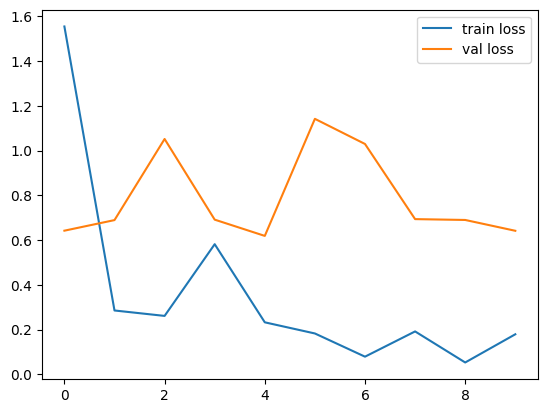

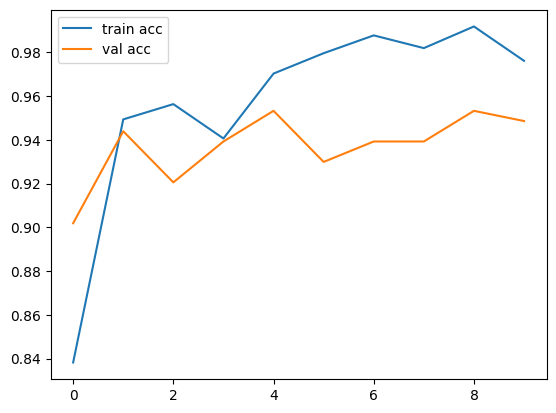

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plot the loss

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

<Axes: >

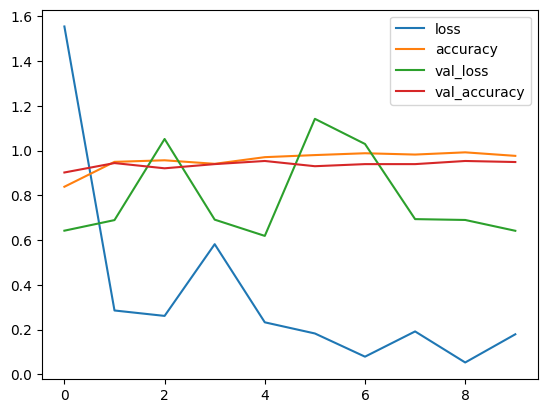

In [ ]:
import pandas as pd

pd.DataFrame(model.history.history).plot()

 **Making predictions**

In [ ]:

y_pred = model.predict(test_set, verbose=1)

15/15 [==============================] - 17s 1s/step


In [ ]:
test_set.class_indices

{'healthy': 0, 'unhealthy': 1}

In [ ]:
test_accu = model.evaluate(test_set)
print('The testing accuracy is :',test_accu[1]*100, '%')

15/15 [==============================] - 14s 943ms/step - loss: 2.2283 - accuracy: 0.8898
The testing accuracy is : 88.98305296897888 %


In [ ]:
preds = model.predict(test_set,verbose=1)

15/15 [==============================] - 15s 931ms/step


15/15 [==============================] - 14s 951ms/step
predicted_labels [0 1 0 0 1 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 0 1 1 1
 0 0 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0
 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1
 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 1 0 0 0 1 0 0
 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 0 0 1
 0 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 1
 1 1 0 1 1 1 0 1 1 0 1 1 0 1]
true_labels [0 1 0 0 1 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 0 1 1 1
 0 0 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0
 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1
 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 1 0 0 0 1 0 0
 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 0 0 1
 0 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1

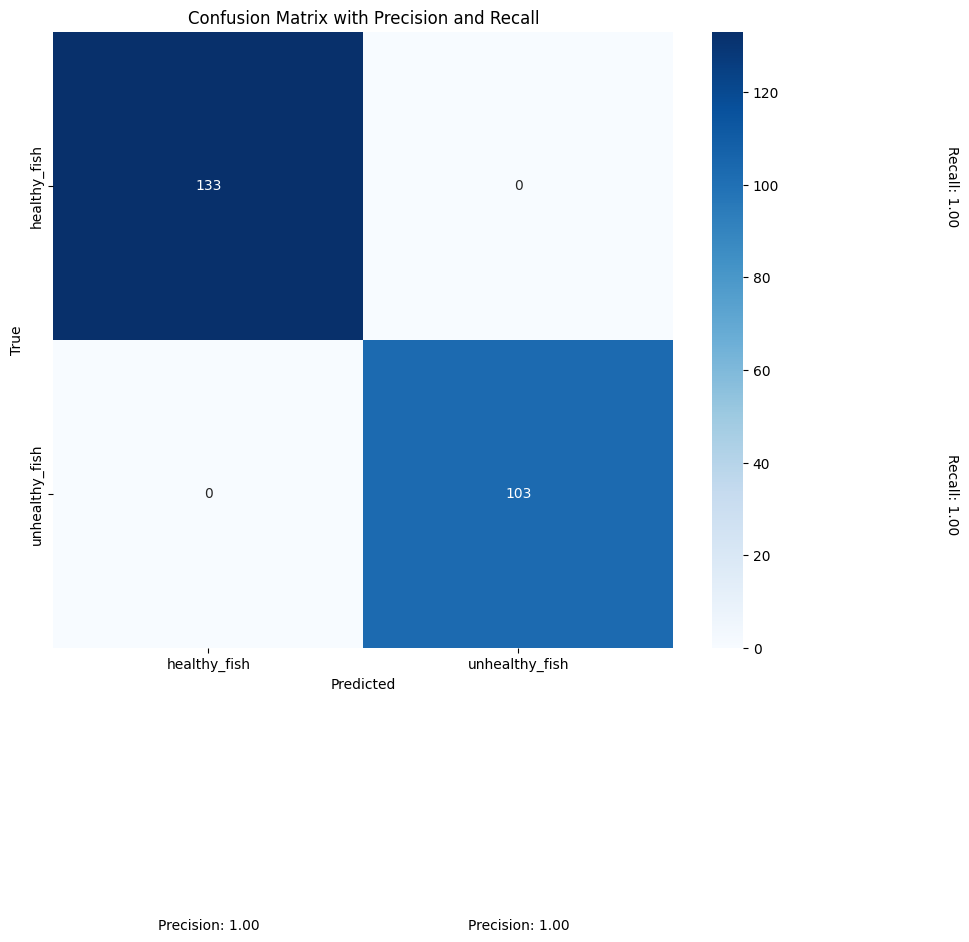

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Collect predicted and true labels
y_pred=model.predict(test_set)
y_true = np.argmax(y_pred, axis=1)

predicted_labels = y_true   # List of predicted labels
print("predicted_labels",predicted_labels)
true_labels = np.argmax(y_pred, axis=1)      # List of true labels
print("true_labels",true_labels)

# Step 2: Define classes
classes = ['healthy_fish', 'unhealthy_fish']
# Step 3: Create an empty confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Step 4: Calculate precision and recall
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

# Step 5: Visualize the confusion matrix with precision and recall
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")

# Add precision values to the plot
for i, class_name in enumerate(classes):
    plt.text(i + 0.5, len(classes) + 0.9, f"Precision: {precision[i]:.2f}", ha="center", va="center")

# Add recall values to the plot
for i, class_name in enumerate(classes):
    plt.text(len(classes) + 0.9, i + 0.5, f"Recall: {recall[i]:.2f}", ha="center", va="center", rotation=270)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix with Precision and Recall")
plt.show()


In [ ]:
# save it as a h5 file

from tensorflow.keras.models import load_model

model.save('health_clssfy_inceptionv3.h5')

In [ ]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model2_inception.h5')
!cp /content/model2_inception.h5 /content/drive/MyDrive/ #saving on drive